### Starting over with the LSTM model ... 

File initially created 6/5/2025. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-24 15:56:47.930008: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 15:56:47.961425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 15:56:47.961447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 15:56:47.962410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 15:56:47.967506: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.15.0


In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
# load input solvers
infile = open("../../reduced_data/PCs/U_14.p","rb",)
U_PC = pickle.load(infile)  ##zonal mean wind
infile.close()

infile = open("../../reduced_data/PCs/EHF_14.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../reduced_data/PCs/GPH_14.p","rb",)
GPH_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

In [5]:
##remove PC 1
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

In [6]:
U_PC.shape

(9238, 9)

In [7]:
# load output data
infile = open("../../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
infile.close()

In [8]:
output.shape

(9238,)

In [9]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=1) 

In [10]:
##make pandas dataframe for RF
input = pd.DataFrame(inputvar)
input

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.791039,-1.727149,1.481165,-1.684007,0.329935,1.656387,-0.211460,1.453994,0.837609,0.195595,...,0.172799,1.564267,0.584225,-0.036226,0.870949,0.482494,0.197297,0.694999,-0.395420,-1.128227
1,0.821552,-1.842438,1.416795,-1.725300,-0.155038,2.059544,0.081825,1.419269,0.147530,0.234372,...,-0.436175,1.686121,0.834128,0.081523,0.887701,0.621646,0.388313,0.968120,-0.156091,-1.539525
2,0.888491,-1.958864,1.626327,-1.405833,-0.030527,1.728328,0.536282,0.792897,-1.002197,0.268253,...,0.480251,1.535731,1.169094,0.118023,0.852785,0.684715,0.481477,0.804988,0.313862,-1.607084
3,0.883083,-1.953125,1.878820,-0.966085,0.620002,1.275088,0.679312,1.133707,-0.758163,0.231512,...,-0.880181,1.224010,1.292322,-0.031788,0.794642,0.805009,0.279682,0.627936,0.181622,-0.832041
4,0.799762,-1.914598,1.794036,-0.578514,1.147515,0.969589,0.594968,1.942123,-0.141386,0.126057,...,-0.636755,0.993273,1.244127,-0.186460,0.879478,1.131472,0.345422,0.342985,0.390064,0.147311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9233,0.739117,0.344881,-1.039941,1.907440,-0.463413,1.368651,1.955351,-1.003432,-1.171885,-0.032577,...,0.667313,0.159405,1.871430,1.036272,-0.931433,-0.594206,1.060108,0.489458,0.632401,1.478229
9234,0.708051,0.610486,-0.735913,1.811668,1.011904,0.905560,2.091698,-0.923073,-0.182186,0.100459,...,0.677382,0.532989,1.945315,1.078350,-0.883960,-0.255287,1.054779,0.616516,0.933306,0.541883
9235,0.612392,0.813433,-0.491388,1.058656,2.158425,0.531745,2.458308,-0.798223,1.449475,0.138989,...,0.355340,1.044255,1.904598,0.936523,-1.013030,-0.031661,1.253826,0.375767,0.830058,-0.412274
9236,0.179745,0.300776,-0.592462,-0.004740,2.092489,-0.249596,1.450899,-0.071044,2.113109,0.101430,...,-0.112332,1.295592,1.709359,0.596902,-1.099654,-0.021087,1.714048,0.279814,0.649183,-0.773683


In [11]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]
print(temp.shape)

temp_flat = temp.flatten()

(62, 135)


In [12]:
#selected indices
#EUROPE
#input[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]

##CANADA
#input[[56, 1, 0, 55, 2, 53, 22, 57, 9, 25, 11, 4, 54, 38, 17, 30, 36, 3, 14, 26]]

##SE US
#input[[56, 1, 54, 18, 53, 3, 0, 10, 5, 19, 21, 14, 2, 57, 13, 60, 22, 26,25, 11]]

In [13]:
#create pd datafram of selected feature columns.
sele_ind_df = input[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]

n_features = 20

In [14]:
#look at new input array
sele_ind_df

,1,56,0,54,9,57,2,31,26,14,20,6,11,38,21,18,15,22,12,13
0,-1.727149,0.870949,0.791039,0.584225,0.195595,0.482494,1.481165,-0.840203,-0.190102,0.057985,-0.773881,-0.211460,-0.443124,-0.130601,0.202801,-0.186997,-0.187630,-0.032653,-0.019193,0.376977
1,-1.842438,0.887701,0.821552,0.834128,0.234372,0.621646,1.416795,0.061981,0.047160,0.038753,-0.324938,0.081825,-0.373201,0.321552,0.467937,-0.598541,-0.270955,0.027107,-0.049397,0.386002
2,-1.958864,0.852785,0.888491,1.169094,0.268253,0.684715,1.626327,0.298515,-0.432859,0.009860,-0.306709,0.536282,-0.265632,0.342450,0.137449,-0.366524,-0.253419,0.012183,0.024585,0.317177
3,-1.953125,0.794642,0.883083,1.292322,0.231512,0.805009,1.878820,0.660462,-0.094418,0.000942,0.019133,0.679312,-0.231309,0.463792,0.329118,-0.513304,-0.236251,-0.282491,0.136366,0.271059
4,-1.914598,0.879478,0.799762,1.244127,0.126057,1.131472,1.794036,0.447582,-0.096808,-0.171956,0.254848,0.594968,-0.224626,0.005776,-0.106193,-0.430760,-0.154636,-0.166812,0.192114,0.207816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9233,0.344881,-0.931433,0.739117,1.871430,-0.032577,-0.594206,-1.039941,-0.509073,-0.257606,-0.355304,-0.337902,1.955351,0.696732,-0.993664,-0.459643,-0.780476,0.085641,0.103523,1.020420,-0.827579
9234,0.610486,-0.883960,0.708051,1.945315,0.100459,-0.255287,-0.735913,-0.484002,0.104951,-0.734529,-0.387806,2.091698,0.528793,-0.712909,0.187002,-0.496463,-0.079321,0.201060,0.726277,-0.338853
9235,0.813433,-1.013030,0.612392,1.904598,0.138989,-0.031661,-0.491388,-0.967253,-0.227728,-0.252240,-0.915382,2.458308,0.276310,0.378725,0.115268,-0.112195,0.129463,-0.507578,0.114448,0.129632
9236,0.300776,-1.099654,0.179745,1.709359,0.101430,-0.021087,-0.592462,-1.556661,-0.148204,0.084979,-2.017825,1.450899,0.127205,0.196277,0.509032,0.827147,0.147253,-0.492190,0.008271,0.058502


In [15]:
#turn input array into (# samples, 14 days, 10 features)
sele_ind_data = sele_ind_df.values
sele_ind_data1 = sele_ind_data.reshape(62,149,n_features)

In [16]:
sele_ind_data.shape

(9238, 20)

In [17]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,lead,14,n_features))
new_output = np.empty((62,lead))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = sele_ind_data1[i,j:j+14,:]
        new_output[i,j] = temp[i,j]

In [18]:
new_input = np.array(new_input)
new_output = np.array(new_output)
print(new_input.shape)
print(new_output.shape)

(62, 135, 14, 20)
(62, 135)


In [19]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)
frac_end

7114

In [20]:
frac_ind

1256

In [21]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*lead),14,n_features))
Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [22]:
Y_all.shape

(8370, 2)

In [23]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [24]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [25]:
##number of input nodes
numb_int = X_all.shape[1:]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [26]:
Y_train.shape

(5858, 2)

In [27]:
numb_int

(14, 20)

### Model Architecture. 

In [28]:
######
batch_size = 64 #The number of samples the network sees before it backpropagates (batch size)
epochs = 30 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [29]:
def categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Cross-entropy loss
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Compute focal loss scaling factor
        focal_factor = tf.pow(1 - y_pred, gamma)
        loss = alpha * focal_factor * cross_entropy

        return tf.reduce_sum(loss, axis=1)  # sum across classes per sample

    return loss

In [30]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [42]:
#model
def basic_LSTM(ntimestep, nfeature, n1, n2, n3, rl1, rl3, lr):  
    input_tensor = Input(shape=(ntimestep, nfeature))
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          dropout=0.331, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=False)(input_tensor)
       
    #layer2 = layers.RNN(
        #layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          #kernel_initializer='glorot_uniform',
                          #kernel_regularizer=keras.regularizers.l2(l2= rl1)))(layer1)
    
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer1)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    loss = 'categorical_crossentropy' #categorical_focal_loss(alpha=0.7, gamma=0.5)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss=loss,metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [43]:
tf.keras.backend.clear_session()

In [44]:
model = basic_LSTM(numb_int[0],numb_int[1], 64, 16, 16, 0.3, 0.2, 0.0006466)
#model = basic_LSTM(numb_int[0],numb_int[1], 64, 16, 16, 0.3, 0.2, 0.000765)
#model = basic_LSTM(numb_int[0],numb_int[1], 64, 16, 16, 0.208, 0.177, 0.0006466) ###OG


In [45]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
#class_weight
#class_weight = {0: 1.0, 1: 2.0}

#class_weight = {0: 1.0, 1: 1.83}

In [46]:
#{0: 1.0, 1: 1.8068999}

In [47]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, class_weight=class_weight, shuffle=shuffle)#, callbacks=[stop_early])

Train on 5858 samples, validate on 1256 samples


2025-06-24 15:57:45.513780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 990 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:2d:00.0, compute capability: 9.0
2025-06-24 15:57:45.635968: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/rnn/lstm_cell/kernel/v/Assign' id:903 op device:{requested: '', assigned: ''} def:{{{node training/Adam/rnn/lstm_cell/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/rnn/lstm_cell/kernel/v, training/Adam/rnn/lstm_cell/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30
5858/5858 [==============================] - 2s 357us/sample - loss: 11.5243 - categorical_accuracy: 0.6270 - val_loss: 6.8415 - val_categorical_accuracy: 0.6131
Epoch 2/30
  64/5858 [..............................] - ETA: 0s - loss: 7.0739 - categorical_accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5858/5858 [==============================] - 1s 98us/sample - loss: 4.8901 - categorical_accuracy: 0.6374 - val_loss: 3.1693 - val_categorical_accuracy: 0.6226
Epoch 3/30
5858/5858 [==============================] - 1s 98us/sample - loss: 2.5883 - categorical_accuracy: 0.6320 - val_loss: 1.8335 - val_categorical_accuracy: 0.6162
Epoch 4/30
5858/5858 [==============================] - 1s 98us/sample - loss: 1.7006 - categorical_accuracy: 0.6284 - val_loss: 1.2557 - val_categorical_accuracy: 0.6513
Epoch 5/30
5858/5858 [==============================] - 1s 98us/sample - loss: 1.2938 - categorical_accuracy: 0.6374 - val_loss: 0.9895 - val_categorical_accuracy: 0.6146
Epoch 6/30
5858/5858 [==============================] - 1s 97us/sample - loss: 1.0856 - categorical_accuracy: 0.6403 - val_loss: 0.8289 - val_categorical_accuracy: 0.6425
Epoch 7/30
5858/5858 [==============================] - 1s 98us/sample - loss: 0.9734 - categorical_accuracy: 0.6463 - val_loss: 0.7408 - val_categorical_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-06-24 15:58:04.634106: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:488 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

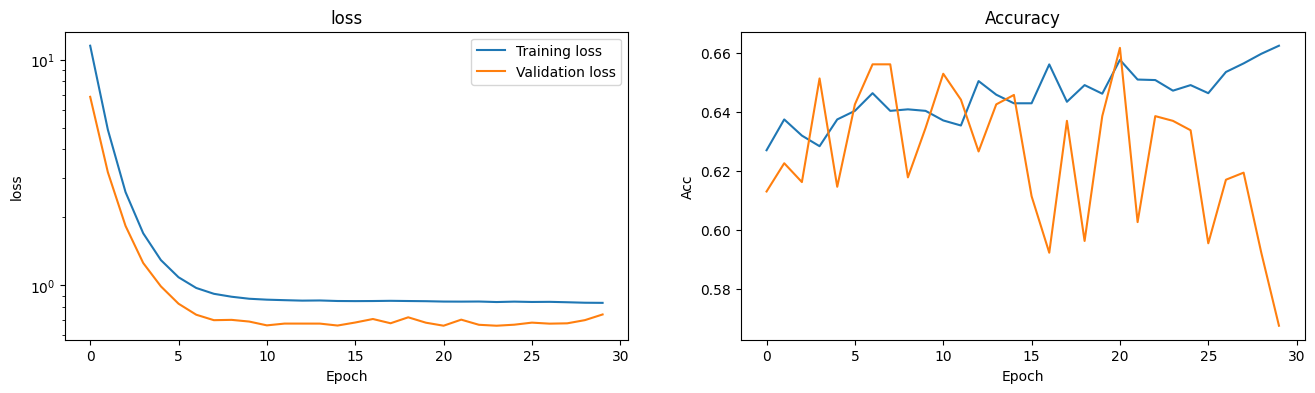

In [48]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend
#plt.savefig("SEUS_onearch.png")

In [49]:
from sklearn.metrics import classification_report
import numpy as np

y_val_pred = model.predict(X_validation)
y_val_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_validation, axis=1)

print(classification_report(y_val_true, y_val_classes, digits=3))

              precision    recall  f1-score   support

           0      0.768     0.522     0.622       854
           1      0.396     0.664     0.496       402

    accuracy                          0.568      1256
   macro avg      0.582     0.593     0.559      1256
weighted avg      0.649     0.568     0.581      1256



In [50]:
# Convert one-hot labels to 1D integer labels (0 or 1)
y_true = np.argmax(Y_test, axis=1)

# Extract predicted probability for the positive class (class 1)
y_prob = pred_test[:,1]

# Create climatology baseline: constant probability = mean positive class rate
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

# Compute Brier Scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)

# Compute Brier Skill Score
bss = 1 - (bs_model / bs_climo)

print(f"Brier Score (Model): {bs_model:.4f}")
print(f"Brier Score (Climatology): {bs_climo:.4f}")
print(f"Brier Skill Score: {bss:.4f}")

Brier Score (Model): 0.2569
Brier Score (Climatology): 0.2330
Brier Skill Score: -0.1029


In [51]:
## Labels for negative class
y_true_neg = 1 - y_true  # flip 0 <-> 1

# Predicted probabilities for negative class
y_prob_neg = pred_test[:, 0]

# Calculate Brier Score and BSS for negative class
bs_model_neg = brier_score_loss(y_true_neg, y_prob_neg)
bs_climo_neg = brier_score_loss(y_true_neg, np.full_like(y_true_neg, y_true_neg.mean()))
bss_neg = 1 - (bs_model_neg / bs_climo_neg)

print(f"Brier Score (Model): {bs_model_neg:.4f}")
print(f"Brier Score (Climatology): {bs_climo_neg:.4f}")
print(f"Brier Skill Score: {bss_neg:.4f}")

Brier Score (Model): 0.2569
Brier Score (Climatology): 0.6306
Brier Skill Score: 0.5925


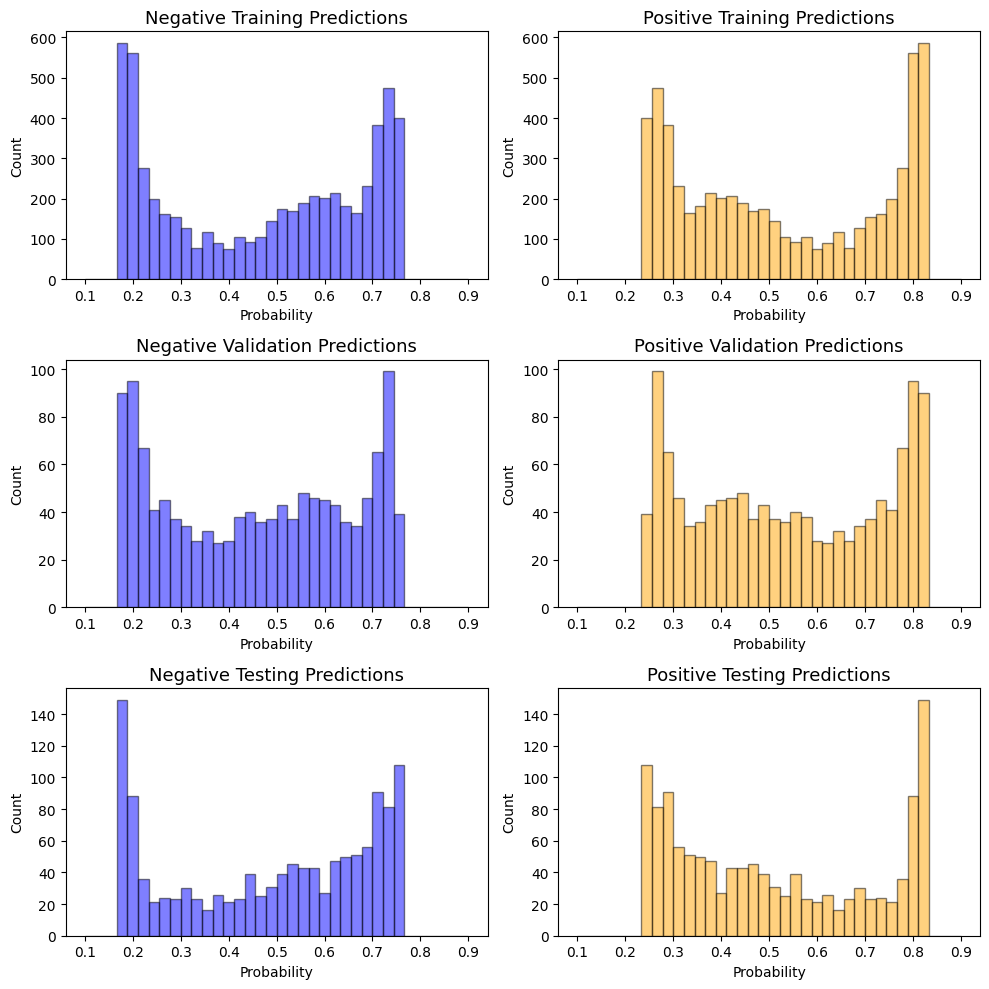

In [52]:
bins = np.linspace(0.1, 0.9, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()

### Try SHAP.

In [53]:
##testing shap
import shap
import pylab
import random

In [54]:
#random range of dates from X_train for explainer
start = random.randrange(len(X_train[:,0])-frac_ind)
end = start+(frac_ind)

In [55]:
print(start)

1834


In [56]:
#use gradient explainer on subset of training data
sample = X_train[start:end]
explainer = shap.GradientExplainer(model, sample)

In [57]:
#use explainer
shap_values = explainer.shap_values(X_train[:100])

2025-06-24 15:58:34.252293: W tensorflow/c/c_api.cc:305] Operation '{name:'rnn/while' id:345 op device:{requested: '', assigned: ''} def:{{{node rnn/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT]{attr_hash=18294461888992254631}, _lower_using_switch_merge=true, _num_original_outputs=83, _read_only_resource_inputs=[9, 10, 11], body=rnn_while_body_2410_rewritten[], cond=rnn_while_cond_2409_rewritten[], output_shapes=[[], [], [], [], [?,64], ..., [], [], [], [], []]{attr_hash=14989673589988053644}, parallel_iterations=32](rnn/while/loop_counter, rnn/while/maximum_iterations, rnn/time, rnn/TensorArrayV2_1, rnn/zeros, rnn/zeros_1, rnn/strided_slice_1, rnn/TensorArrayUnstack/TensorListFromTensor, keras_learning_phase, rnn/lstm_cell/kernel, rnn/lstm_cell/recurrent_kernel, rnn/lstm_cell/bias, rnn/while/EmptyTensorList, rnn/while/EmptyTensorList_1, rnn/while/EmptyTensorList_2, rnn/while/EmptyTensorList_3, rn

In [58]:
#change shap values to array
shap_values = np.array(shap_values)
shap_values.shape

(2, 100, 14, 20)

In [59]:
aggs = np.abs(shap_values) ##aggregate over the samples to make all positive
aggs.shape

(2, 100, 14, 20)

In [60]:
#take mean along sample dimension
aggs = aggs.mean(axis=1)
aggs.shape

(2, 14, 20)

In [61]:
feat_cat = aggs.mean(axis=1) ##take mean along timestep axis
feat_cat.shape
feat_cat_df = pd.DataFrame(feat_cat) #turn into pandas dataframe

In [62]:
feat_cat.shape

(2, 20)

In [63]:
#fetures = ['1', '56', '0', '54', '9', '57', '2', '31', '26', '14','20', '6', '11', '38', '21', '18', '15', '22', '12', '13']

#labels for columns
features = ['U3', 'GPH4', 'U2', 'GPH2', 'EHF2', 'GPH5', 'U4', 'EHF24', 'EHF19', 'EHF7',
            'EHF13', 'U8', 'EHF4', 'EHF31', 'EHF14', 'EHF11', 'EHF8', 'EHF15', 'EHF5', 'EHF6']

In [64]:
#add labels and transpose model
feat_cat_df.columns = features
featcat_df = feat_cat_df.T

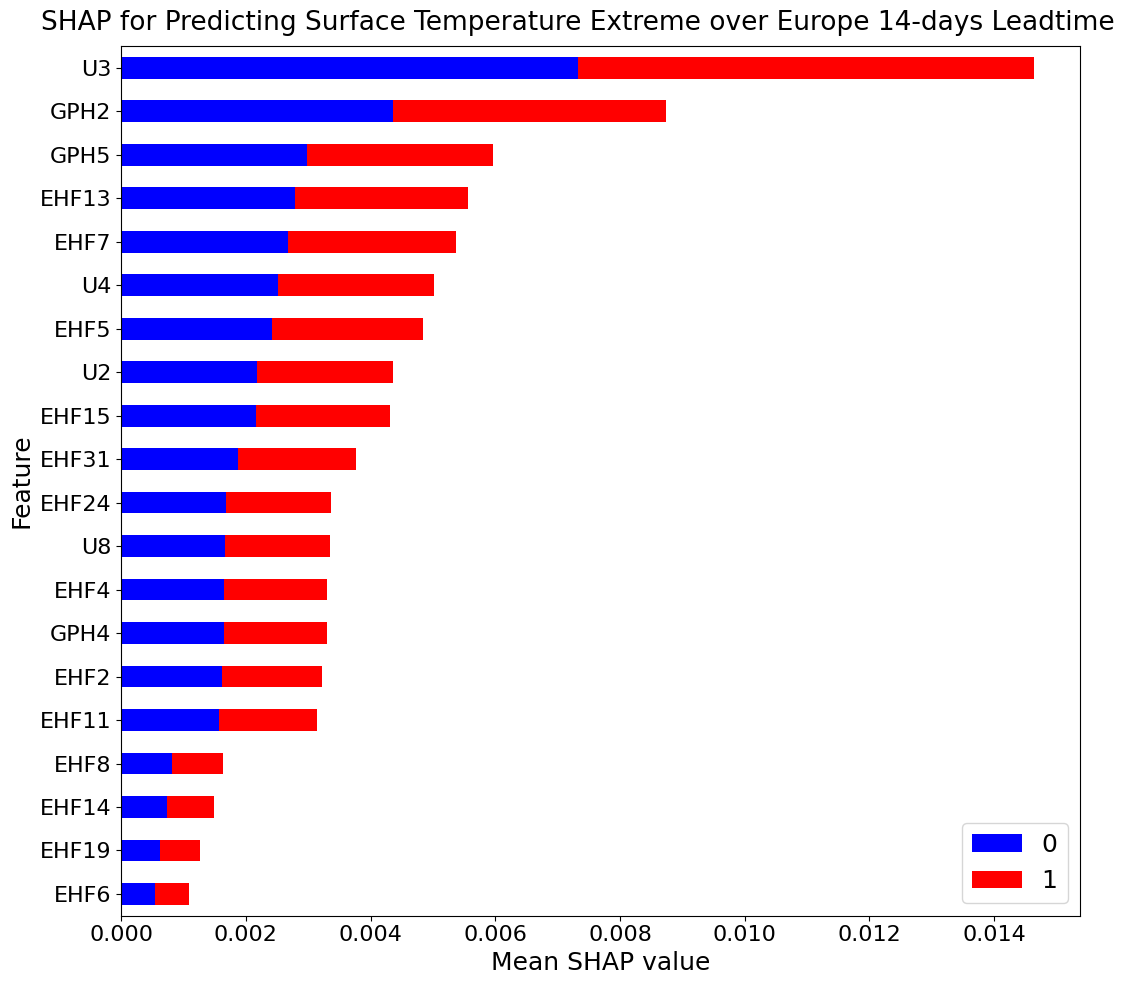

In [65]:
fig = plt.figure(figsize=(11,10),dpi=100)
fig.suptitle("SHAP for Predicting Surface Temperature Extreme over Europe 14-days Leadtime",
             fontsize = 19,x=.53) 
 
ax1 = fig.add_subplot(1,1,1)
featcat_df.loc[featcat_df.sum(1).sort_values(ascending=True).index[:]].plot(
    kind="barh", stacked=True, ax = ax1, colormap = 'bwr')
ax1.tick_params(axis='both', which='major', labelsize= 16)
#ax1.set_yticks([0,1,2,3,4,5,6,7,8],feature_name_bh)
ax1.set_xlabel('Mean SHAP value', fontsize =18 )
ax1.set_ylabel('Feature', fontsize =18 )
ax1.legend(loc = 'lower right', fontsize =18)
#ax1.set_xlim(0,0.25)

plt.tight_layout()
plt.savefig('practice_SHAP.png')

In [66]:
#stuff for creating beeswarm plots
shap_class1_agg = np.mean(shap_values[1], axis=1)  #pos class agg shap values (samples, features)
shap_class0_agg = np.mean(shap_values[0], axis=1)  #neg class agg shap values (samples, features)
X_sample = np.mean(X_train[:100], axis=1) #reference from training for agg shaps(samples, features)

In [67]:
shap_class1_agg.shape

(100, 20)

In [68]:
#separate reference dataframe with column names. 
X_df = pd.DataFrame(X_sample, columns=features)

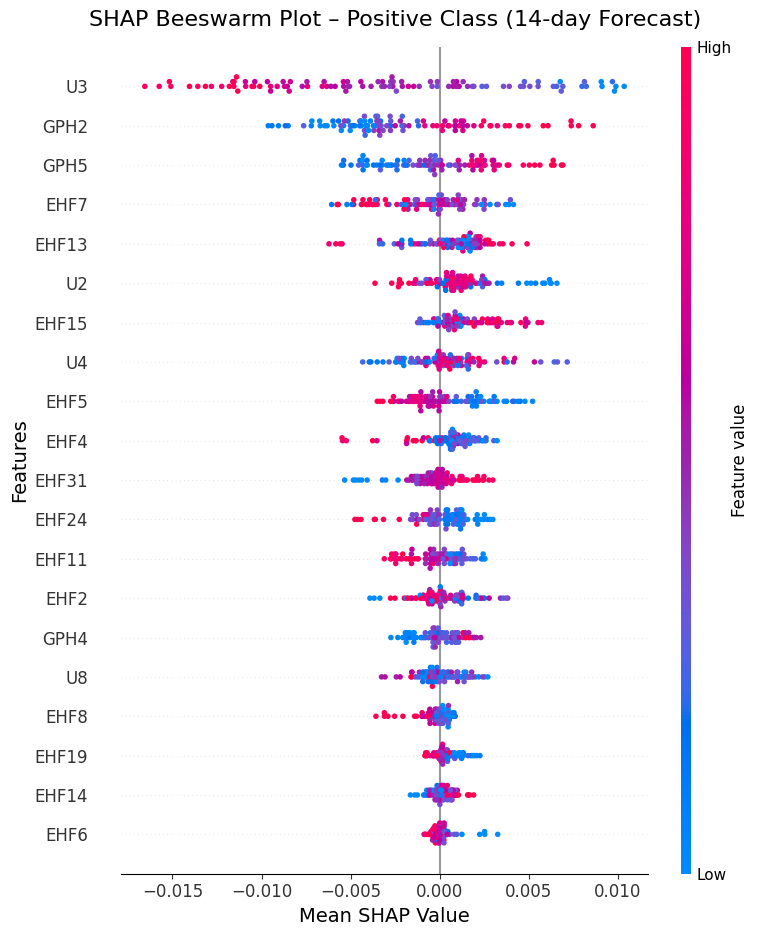

In [69]:
shap.summary_plot(shap_class1_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Positive Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("beeswarm_postest.png")
plt.show()

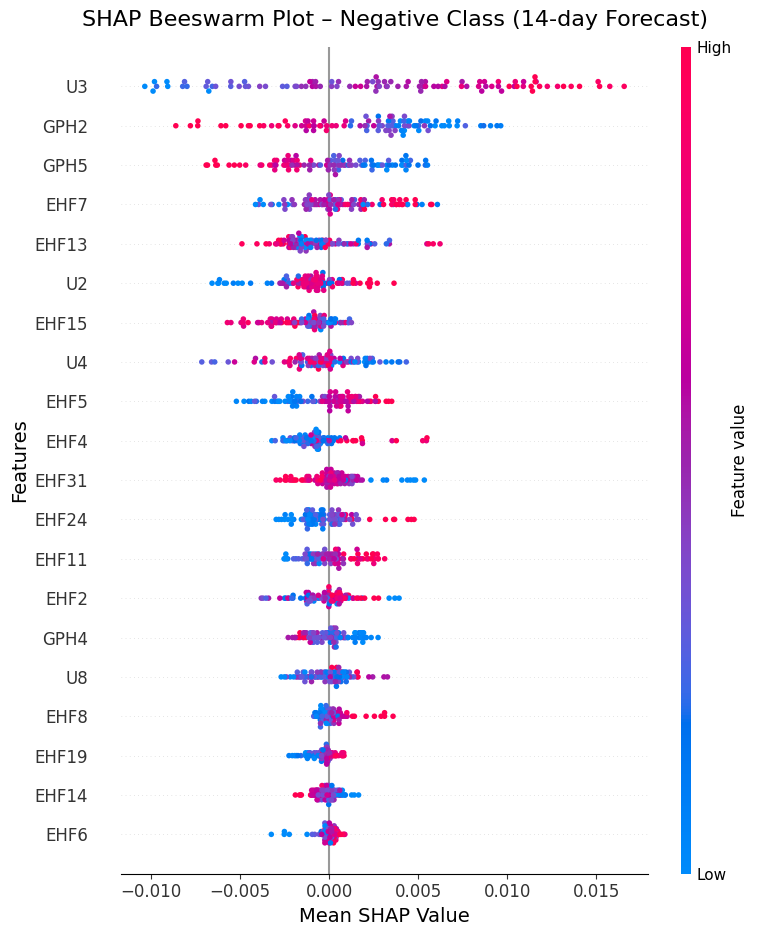

In [70]:
shap.summary_plot(shap_class0_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Negative Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("beeswarm_negtest.png")
plt.show()